# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest

In [2]:
def plot_tracked_particles(trackdataset, ax, i):
    """
    Plot tracked particles in the subplot ax

    Parameters
    ----------
    trackdataset : xarray.Dataset
        Dataset containing the tracked particles
    ax : matplotlib.axes._subplots.AxesSubplot
        Subplot to plot the tracked particles
    i : int
        Current time step
    """
    x_track = trackdataset.xtrack.values[::-1]
    z_track = trackdataset.ztrack.values[::-1]
    P = trackdataset.ptrack.values[::-1]
    T = trackdataset.ttrack.values[::-1]
    time = trackdataset.time.values[::-1]
    steps = trackdataset.step.values[::-1]
    n = int(trackdataset.ntracked.values)
    nTotal = np.size(x_track)
    steps = nTotal//n

    x_track = np.reshape(x_track,(steps,n))
    z_track = np.reshape(z_track,(steps,n))
    P = np.reshape(P,(steps,n))
    T = np.reshape(T,(steps,n))
    particles_layers = trackdataset.particles_layers.values[::-1] #code of the tracked layers

    mlit_code = 1
    lower_crust_code = 4
    T_initial = T[0]

    if(mlit_code in particles_layers):
        cond_mlit = particles_layers == mlit_code
        particles_mlit = particles_layers[cond_mlit]

        T_initial_mlit = T_initial[cond_mlit] #initial temperature of lithospheric mantle particles
        T_initial_mlit_sorted = np.sort(T_initial_mlit)

        Ti_mlit_max = np.max(T_initial_mlit_sorted)
        mid_index = len(T_initial_mlit_sorted)//2
        Ti_mlit_mid = T_initial_mlit_sorted[mid_index]
        Ti_mlit_min = np.min(T_initial_mlit_sorted)

        cond_mlit2plot = (T_initial == Ti_mlit_min) | (T_initial == Ti_mlit_mid) | (T_initial == Ti_mlit_max)

        plot_mlit_particles = True

        dict_mlit_markers = {Ti_mlit_max: '*',
                            Ti_mlit_mid: '^',
                            Ti_mlit_min: 'D'}

        dict_mlit_colors = {Ti_mlit_min: 'xkcd:cerulean blue',
                            Ti_mlit_mid: 'xkcd:scarlet',
                            Ti_mlit_max: 'xkcd:dark green'}
    else:
        plot_mlit_particles = False
        cond_mlit2plot = np.arange(0, n, 1) == np.arange(0, n, 1) + 1

    if(lower_crust_code in particles_layers):
        cond_crust = particles_layers == lower_crust_code
        particles_crust = particles_layers[cond_crust]

        T_initial_crust = T_initial[cond_crust] #initial temperature of crustal particles
        T_initial_crust_sorted = np.sort(T_initial_crust)

        Ti_crust_max = np.max(T_initial_crust_sorted)
        mid_index = len(T_initial_crust_sorted)//2
        Ti_crust_mid = T_initial_crust_sorted[mid_index]
        Ti_crust_min = np.min(T_initial_crust_sorted)

        cond_crust2plot = (T_initial == Ti_crust_min) | (T_initial == Ti_crust_mid) | (T_initial == Ti_crust_max)
        plot_crust_particles = True
    else:
        plot_crust_particles = False
        cond_crust2plot = np.arange(0, n, 1) == np.arange(0,n,1) + 1

    # linewidth = 0.85
    markersize = 12
    color_crust='xkcd:grey'
    h_air = 40.0
    for particle, particle_layer, mlit2plot in zip(range(n), particles_layers, cond_mlit2plot):
        #Plot particles in prop subplot

        if(plot_crust_particles == True):
            if(particle_layer != mlit_code): #crustal particles
                # print(particle_layer)
                if(cond_crust2plot[particle] == True):
                    ax.plot(x_track[i, particle]/1.0e3, z_track[i, particle]/1.0e3+h_air, '.', color=color_crust, markersize=markersize-2, zorder=60)


        if(plot_mlit_particles == True): #lithospheric mantle particles
            if(particle_layer == mlit_code):
                if(mlit2plot==True):
                    # print(f"Particle: {particle}, Layer: {particle_layer}, T_initial: {T_initial[particle]}")
                    ax.plot(x_track[i, particle]/1.0e3, z_track[i, particle]/1.0e3+h_air,
                                dict_mlit_markers[T_initial[particle]],
                                color=dict_mlit_colors[T_initial[particle]],
                                markersize=markersize-2, zorder=60)

def plot_ptt_paths(trackdataset, ax, instants=[]):
    """
    Plot PTt path of tracked particles in the subplot ax

    Parameters
    ----------
    trackdataset : xarray.Dataset
        Dataset containing the tracked particles
    ax : matplotlib.axes._subplots.AxesSubplot
        Subplot to plot the PTt path
    instants : list
        List of instants to plot the PTt path
    """
    x_track = trackdataset.xtrack.values[::-1]
    z_track = trackdataset.ztrack.values[::-1]
    P = trackdataset.ptrack.values[::-1]
    T = trackdataset.ttrack.values[::-1]
    time = trackdataset.time.values[::-1]
    steps = trackdataset.step.values[::-1]
    n = int(trackdataset.ntracked.values)
    nTotal = np.size(x_track)
    steps = nTotal//n

    x_track = np.reshape(x_track,(steps,n))
    z_track = np.reshape(z_track,(steps,n))
    P = np.reshape(P,(steps,n))
    T = np.reshape(T,(steps,n))
    particles_layers = trackdataset.particles_layers.values[::-1] #code of the tracked layers

    mlit_code = 1
    lower_crust_code = 4
    T_initial = T[0]

    if(mlit_code in particles_layers):
        cond_mlit = particles_layers == mlit_code
        particles_mlit = particles_layers[cond_mlit]

        T_initial_mlit = T_initial[cond_mlit] #initial temperature of lithospheric mantle particles
        T_initial_mlit_sorted = np.sort(T_initial_mlit)

        Ti_mlit_max = np.max(T_initial_mlit_sorted)
        mid_index = len(T_initial_mlit_sorted)//2
        Ti_mlit_mid = T_initial_mlit_sorted[mid_index]
        Ti_mlit_min = np.min(T_initial_mlit_sorted)

        cond_mlit2plot = (T_initial == Ti_mlit_min) | (T_initial == Ti_mlit_mid) | (T_initial == Ti_mlit_max)

        plot_mlit_particles = True

        dict_mlit_markers = {Ti_mlit_max: '*',
                            Ti_mlit_mid: '^',
                            Ti_mlit_min: 'D'}

        dict_mlit_colors = {Ti_mlit_min: 'xkcd:cerulean blue',
                            Ti_mlit_mid: 'xkcd:scarlet',
                            Ti_mlit_max: 'xkcd:dark green'}
    else:
        plot_mlit_particles = False
        cond_mlit2plot = np.arange(0, n, 1) == np.arange(0, n, 1) + 1

    if(lower_crust_code in particles_layers):
        cond_crust = particles_layers == lower_crust_code
        particles_crust = particles_layers[cond_crust]

        T_initial_crust = T_initial[cond_crust] #initial temperature of crustal particles
        T_initial_crust_sorted = np.sort(T_initial_crust)

        Ti_crust_max = np.max(T_initial_crust_sorted)
        mid_index = len(T_initial_crust_sorted)//2
        Ti_crust_mid = T_initial_crust_sorted[mid_index]
        Ti_crust_min = np.min(T_initial_crust_sorted)

        cond_crust2plot = (T_initial == Ti_crust_min) | (T_initial == Ti_crust_mid) | (T_initial == Ti_crust_max)
        plot_crust_particles = True
    else:
        plot_crust_particles = False
        cond_crust2plot = np.arange(0, n, 1) == np.arange(0,n,1) + 1

    linewidth = 0.85
    markersize = 10
    color_crust='xkcd:grey'

    for particle, particle_layer, mlit2plot in zip(range(n), particles_layers, cond_mlit2plot):
        #Plot particles in prop subplot

        if(plot_crust_particles == True):
            if(particle_layer != mlit_code): #crustal particles
                # print(particle_layer)
                if(cond_crust2plot[particle] == True):
                    ax.plot(T[::, particle], P[::, particle], '-', color=color_crust, linewidth=linewidth, alpha=1.0, zorder=60) #PTt path
                    
                    if(len(instants)>0):
                        for instant in instants:
                            idx = find_nearest(time, instant)
                            ax.plot(T[idx, particle], P[idx, particle], '.', color=color_crust, markersize=markersize)
                    else: #plotting points at each 5 Myr
                        for j in np.arange(0, time[-1], 5):
                            idx = find_nearest(time, j)
                            ax.plot(T[idx, particle], P[idx, particle], '.', color=color_crust, markersize=markersize)


        if(plot_mlit_particles == True): #lithospheric mantle particles
            if(particle_layer == mlit_code):
                if(mlit2plot==True):
                    ax.plot(T[::, particle], P[::, particle], '-', color=dict_mlit_colors[T_initial[particle]], linewidth=linewidth, alpha=0.8, zorder=60) #PTt path
                    
                    if(len(instants)>0):
                        for instant in instants:
                            idx = find_nearest(time, instant)
                            ax.plot(T[idx, particle], P[idx, particle], dict_mlit_markers[T_initial[particle]], color=dict_mlit_colors[T_initial[particle]], markersize=markersize)
                    else: #plotting points at each 5 Myr
                        for j in np.arange(0, time[-1], 5):
                            idx = find_nearest(time, j)
                            ax.plot(T[idx, particle], P[idx, particle], dict_mlit_markers[T_initial[particle]], color=dict_mlit_colors[T_initial[particle]], markersize=markersize)

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [3]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

scenarios = [
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
            ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
             'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)
dataset5 = read_datasets(scenarios[5], new_datasets)
dataset6 = read_datasets(scenarios[6], new_datasets)
dataset7 = read_datasets(scenarios[7], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")
trackdataset6 = xr.open_dataset(f"{scenarios[6]}/_track_xzPT_all_steps.nc")
trackdataset7 = xr.open_dataset(f"{scenarios[7]}/_track_xzPT_all_steps.nc")


<bound method Dataset.info of <xarray.Dataset> Size: 840MB
Dimensions:      (x: 1001, z: 301, time: 87)
Coordinates:
  * x            (x) float64 8kB 0.0 1e+03 2e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 2kB -3e+05 -2.99e+05 -2.98e+05 ... -1e+03 0.0
  * time         (time) float64 696B 0.0 0.5 1.0 1.5 ... 38.59 39.08 39.52 39.93
    step         (time) int32 348B 0 100 200 300 400 ... 8300 8400 8500 8600
Data variables:
    strain       (time, x, z) float64 210MB ...
    density      (time, x, z) float64 210MB ...
    strain_rate  (time, x, z) float64 210MB ...
    surface      (time, x) float64 697kB ...
    temperature  (time, x, z) float64 210MB ...
Attributes: (12/95)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            direct
    ...                     

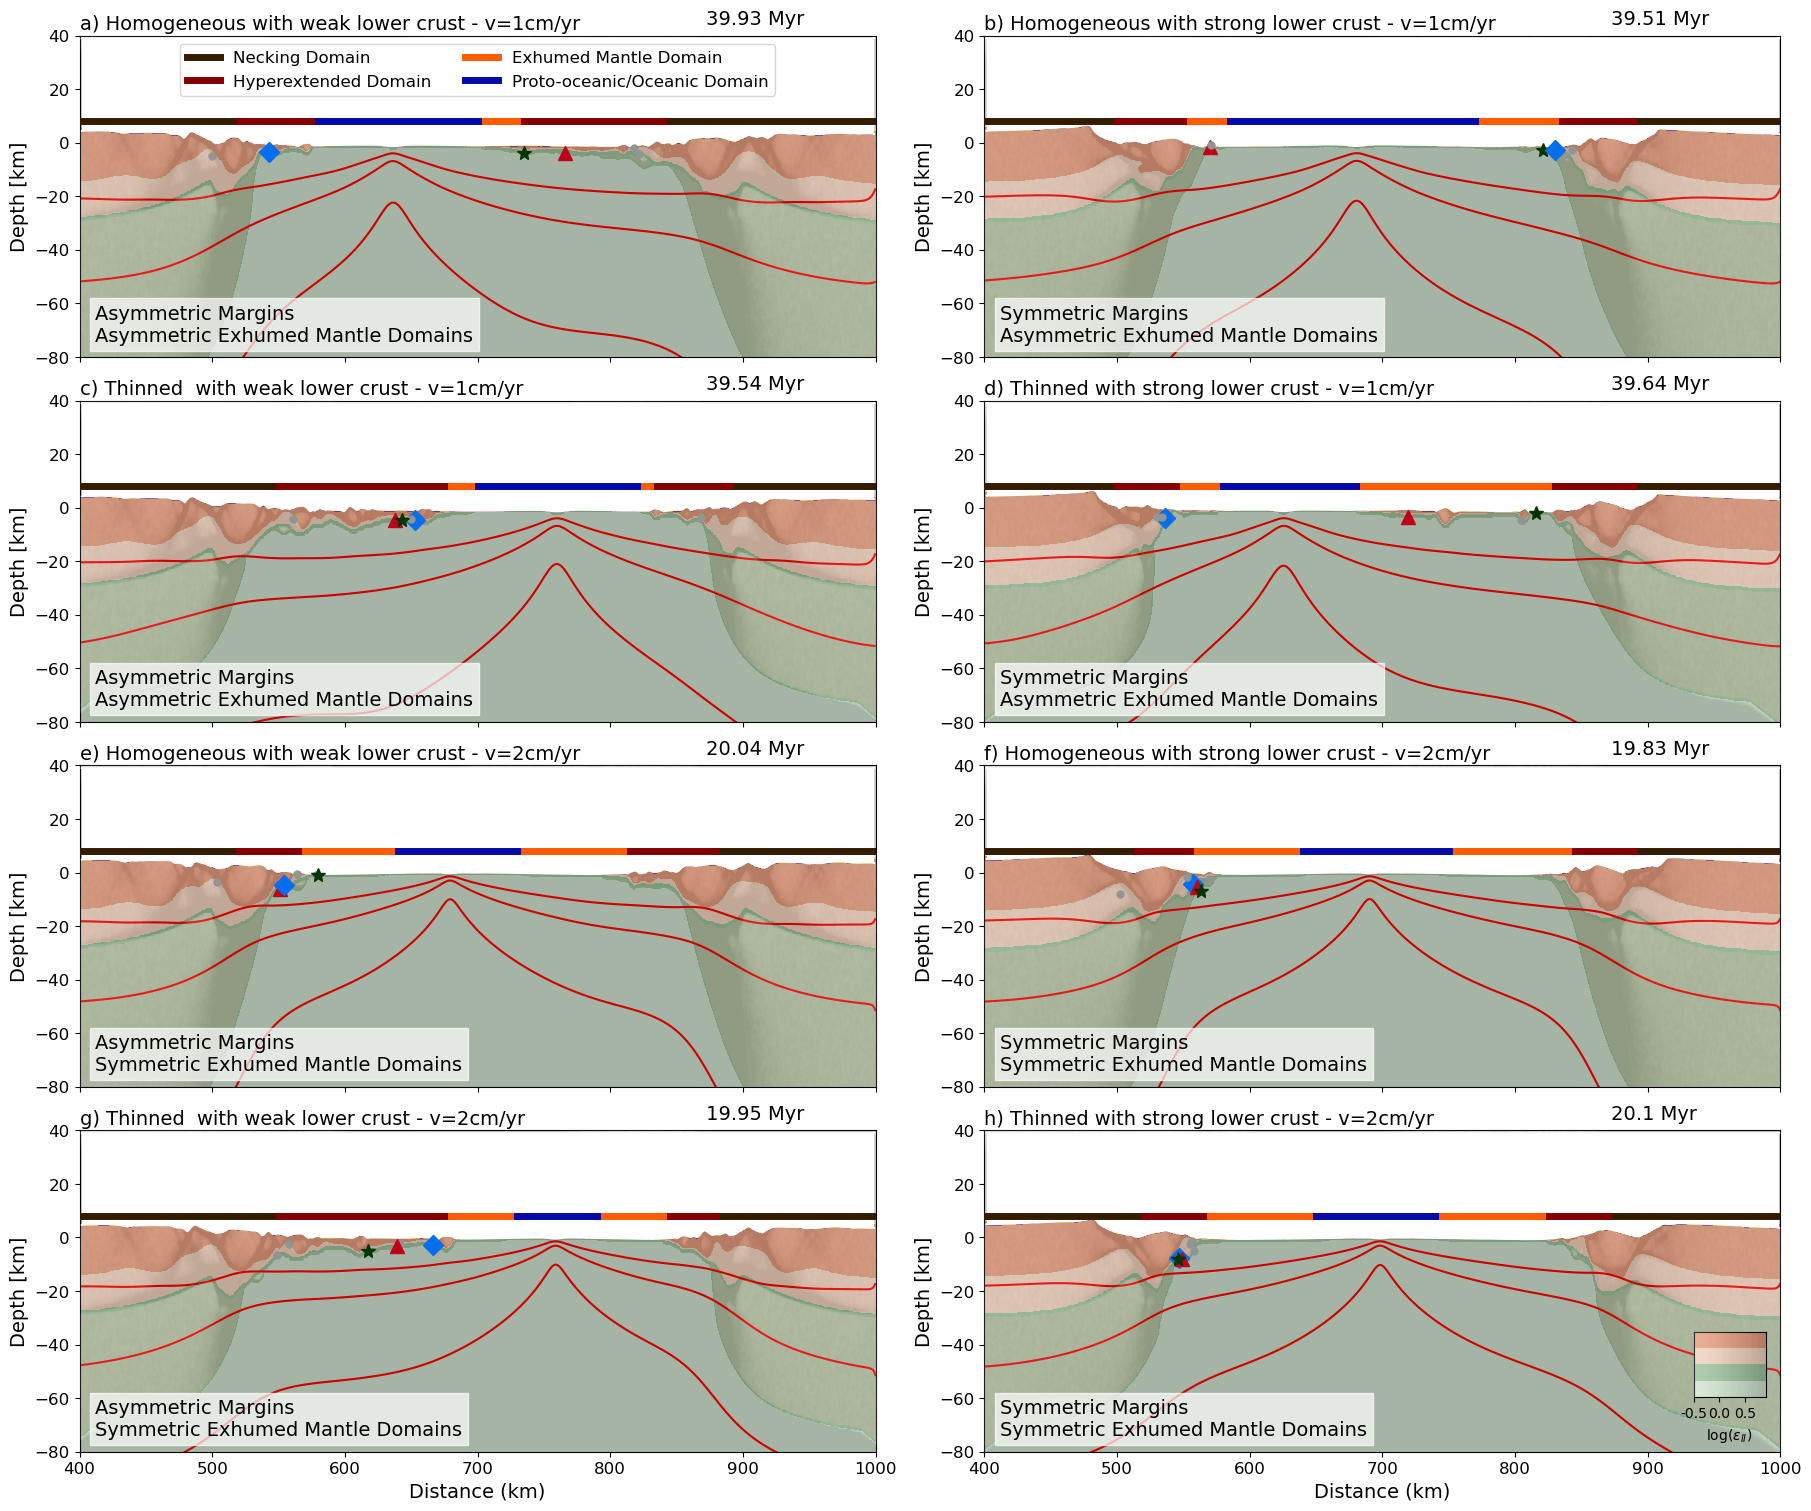

In [54]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

# instants = [0, 10., 20., 30.] #Myr

# instants = [34.59, 27.01, 30.54, 33.14] #Myr
instants = [40, 40, 40, 40, 20, 20, 20, 20] #Myr

datasets_list = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7]
trackdatasets_list = [trackdataset0, trackdataset1, trackdataset2, trackdataset3, trackdataset4, trackdataset5, trackdataset6, trackdataset7]

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 2) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         AB
         CD
         EF
         GH
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
axs_idxs = np.asarray(alphabet[0: len(scenarios)]) #starting at A subplot
idxs_aux = axs_idxs.reshape(int(len(scenarios)/2),2)

xlims = [400, 1000]
ylims = [-80, 40]

for instant, dataset, trackdataset, ax_idx in zip(instants, datasets_list, trackdatasets_list, axs_idxs):
    idx = find_nearest(dataset.time, instant)
    plot_colorbar = True if ax_idx == axs_idxs[-1] else False

    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[ax_idx],
             plot_isotherms = plot_isotherms,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.9,#horizontal position respective to parent_bbox or "loc" position
                            0.15,# vertical position
                            0.09,# width
                            0.2),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset, axs[ax_idx], idx)


fsize = 14
##########################
#Set plot details
##########################
#Titles
axs['A'].text(0.0, 1.02, f"a) Homogeneous with weak lower crust - v=1cm/yr", transform=axs['A'].transAxes, fontsize=fsize)
axs['B'].text(0.0, 1.02, f"b) Homogeneous with strong lower crust - v=1cm/yr", transform=axs['B'].transAxes, fontsize=fsize)
axs['C'].text(0.0, 1.02, f"c) Thinned  with weak lower crust - v=1cm/yr", transform=axs['C'].transAxes, fontsize=fsize)
axs['D'].text(0.0, 1.02, f"d) Thinned with strong lower crust - v=1cm/yr", transform=axs['D'].transAxes, fontsize=fsize)

axs['E'].text(0.0, 1.02, f"e) Homogeneous with weak lower crust - v=2cm/yr", transform=axs['E'].transAxes, fontsize=fsize)
axs['F'].text(0.0, 1.02, f"f) Homogeneous with strong lower crust - v=2cm/yr", transform=axs['F'].transAxes, fontsize=fsize)
axs['G'].text(0.0, 1.02, f"g) Thinned  with weak lower crust - v=2cm/yr", transform=axs['G'].transAxes, fontsize=fsize)
axs['H'].text(0.0, 1.02, f"h) Thinned with strong lower crust - v=2cm/yr", transform=axs['H'].transAxes, fontsize=fsize)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for ax_idx in axs_idxs:
    if(ax_idx == axs_idxs[0] or ax_idx == axs_idxs[2], ax_idx == axs_idxs[4], ax_idx == axs_idxs[6]):
        axs[ax_idx].set_ylabel('Depth [km]', fontsize=label_fsize)
    else:
        axs[ax_idx].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(ax_idx == axs_idxs[-1] or ax_idx == axs_idxs[-2]):
        axs[ax_idx].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[ax_idx].set_xticklabels([])


#Drawring horizontal lines of margins domains
def plot_rift_domains(ax, xnecking_left, xnecking_right, xhyper_left, xhyper_right, xexhumed_left, xexhumed_right, xoceanic, z_bar,
                      color_necking = 'xkcd:dark brown',
                      color_hyperextended = 'xkcd:dark red',
                      color_exhumed_mantle = 'xkcd:bright orange',
                      color_oceanic = 'xkcd:cobalt blue',
                      lw=5):
    #Necking domain
    ax.plot(xnecking_left, z_bar, '-', color=color_necking, lw=lw, zorder=90) #left
    ax.plot(xnecking_right, z_bar, '-', color=color_necking, lw=lw, zorder=90) #right

    #Hyperextended domain
    ax.plot(xhyper_left, z_bar, color=color_hyperextended, lw=lw, zorder=90) #left
    ax.plot(xhyper_right, z_bar, color=color_hyperextended, lw=lw, zorder=90) #right

    #Exhumed mantle domain
    ax.plot(xexhumed_left, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #left
    ax.plot(xexhumed_right, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #right

    #Proto-oceanic/oceanic domain
    ax.plot(xoceanic, z_bar, color=color_oceanic, lw=lw, zorder=90) #left

z_bar = [8, 8]

#Subplot A
xneckingA_left = [400, 520]
xneckingA_right = [840, 1000]
xhyperA_left = [520, 580]
xhyperA_right = [730, 840]
xexhumedA_left = [580, 580]
xexhumedA_right = [700, 730]
xoceanicA = [580, 700]

#Subplot B
xneckingB_left = [400, 500]
xneckingB_right = [890, 1000]
xhyperB_left = [500, 555]
xhyperB_right = [830, 890]
xexhumedB_left = [555, 585]
xexhumedB_right = [770, 830]
xoceanicB = [585, 770]

#Subplot C
xneckingC_left = [400, 550]
xneckingC_right = [890, 1000]
xhyperC_left = [550, 680]
xhyperC_right = [830, 890]
xexhumedC_left = [680, 700]
xexhumedC_right = [820, 830]
xoceanicC = [700, 820]

#Subplot D
xneckingD_left = [400, 500]
xneckingD_right = [890, 1000]
xhyperD_left = [500, 550]
xhyperD_right = [825, 890]
xexhumedD_left = [550, 580]
xexhumedD_right = [680, 825]
xoceanicD = [580, 680]

#Subplot E
xneckingE_left = [400, 520]
xneckingE_right = [880, 1000]
xhyperE_left = [520, 570]
xhyperE_right = [810, 880]
xexhumedE_left = [570, 640]
xexhumedE_right = [730, 810]
xoceanicE = [640, 730]

#Subplot F
xneckingF_left = [400, 515]
xneckingF_right = [890, 1000]
xhyperF_left = [515, 560]
xhyperF_right = [840, 890]
xexhumedF_left = [560, 640]
xexhumedF_right = [750, 840]
xoceanicF = [640, 750]

#Subplot G
xneckingG_left = [400, 550]
xneckingG_right = [880, 1000]
xhyperG_left = [550, 680]
xhyperG_right = [840, 880]
xexhumedG_left = [680, 730]
xexhumedG_right = [790, 840]
xoceanicG = [730, 790]

#Subplot H
xneckingH_left = [400, 520]
xneckingH_right = [870, 1000]
xhyperH_left = [520, 570]
xhyperH_right = [820, 870]
xexhumedH_left = [570, 650]
xexhumedH_right = [740, 820]
xoceanicH = [650, 740]


color_necking = 'xkcd:dark brown'
color_hyperextended = 'xkcd:dark red'
color_exhumed_mantle = 'xkcd:bright orange'
color_oceanic = 'xkcd:cobalt blue'
lw=5

plot_rift_domains(axs['A'], xneckingA_left, xneckingA_right, xhyperA_left, xhyperA_right, xexhumedA_left, xexhumedA_right, xoceanicA, z_bar)
plot_rift_domains(axs['B'], xneckingB_left, xneckingB_right, xhyperB_left, xhyperB_right, xexhumedB_left, xexhumedB_right, xoceanicB, z_bar)
plot_rift_domains(axs['C'], xneckingC_left, xneckingC_right, xhyperC_left, xhyperC_right, xexhumedC_left, xexhumedC_right, xoceanicC, z_bar)
plot_rift_domains(axs['D'], xneckingD_left, xneckingD_right, xhyperD_left, xhyperD_right, xexhumedD_left, xexhumedD_right, xoceanicD, z_bar)
plot_rift_domains(axs['E'], xneckingE_left, xneckingE_right, xhyperE_left, xhyperE_right, xexhumedE_left, xexhumedE_right, xoceanicE, z_bar)
plot_rift_domains(axs['F'], xneckingF_left, xneckingF_right, xhyperF_left, xhyperF_right, xexhumedF_left, xexhumedF_right, xoceanicF, z_bar)
plot_rift_domains(axs['G'], xneckingG_left, xneckingG_right, xhyperG_left, xhyperG_right, xexhumedG_left, xexhumedG_right, xoceanicG, z_bar)
plot_rift_domains(axs['H'], xneckingH_left, xneckingH_right, xhyperH_left, xhyperH_right, xexhumedH_left, xexhumedH_right, xoceanicH, z_bar)


#Bars labels
ax_loc = 'A'
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_necking, lw=lw, zorder=90, label='Necking Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_hyperextended, lw=lw, zorder=90, label='Hyperextended Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_exhumed_mantle, lw=lw, zorder=90, label='Exhumed Mantle Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_oceanic, lw=lw, zorder=90, label='Proto-oceanic/Oceanic Domain')
axs[ax_loc].legend(loc='upper center', ncol=2, fontsize=12).set_zorder(90)

# axs[ax_loc].text(0.02, 0.85, 'Necking Domain', transform=axs[ax_loc].transAxes, fontsize=14, color='xkcd:black', zorder=90)

#Symmetry
alpha=0.7
axs['A'].text(0.02, 0.05, 'Asymmetric Margins\nAsymmetric Exhumed Mantle Domains', transform=axs['A'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['B'].text(0.02, 0.05, 'Symmetric Margins\nAsymmetric Exhumed Mantle Domains', transform=axs['B'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['C'].text(0.02, 0.05, 'Asymmetric Margins\nAsymmetric Exhumed Mantle Domains', transform=axs['C'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['D'].text(0.02, 0.05, 'Symmetric Margins\nAsymmetric Exhumed Mantle Domains', transform=axs['D'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

axs['E'].text(0.02, 0.05, 'Asymmetric Margins\nSymmetric Exhumed Mantle Domains', transform=axs['E'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['F'].text(0.02, 0.05, 'Symmetric Margins\nSymmetric Exhumed Mantle Domains', transform=axs['F'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['G'].text(0.02, 0.05, 'Asymmetric Margins\nSymmetric Exhumed Mantle Domains', transform=axs['G'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['H'].text(0.02, 0.05, 'Symmetric Margins\nSymmetric Exhumed Mantle Domains', transform=axs['H'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

figname = f"RHvsRT_symmetries_v1xv2_{prop}"
fig.savefig(f"figures/{figname}.png", dpi=200)
fig.savefig(f"figures/{figname}.pdf", dpi=200)

In [13]:
instants, idxs_aux

([0, 15.0, 20.0, 25.0, 30.0],
 array([['A', 'B', 'C', 'D', 'E'],
        ['F', 'G', 'H', 'I', 'J'],
        ['K', 'L', 'M', 'N', 'O'],
        ['P', 'Q', 'R', 'S', 'T']], dtype='<U1'))